In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import datetime as dt
import matplotlib.dates as mdates
import numpy as np
from PIL import Image

import json
import requests

import numpy as np
import csv

from datetime import datetime, timedelta


from pandas import read_csv
from pathlib import Path

csv_dir = Path('csvs')

In [2]:
# read all csv files with the exported data points
csvs = sorted([x for x in csv_dir.iterdir() if str(x).endswith('csv')])

In [3]:
# fetch new cases info from koronavirus.hr
url = {}

url['po_danima_zupanijama'] = 'https://www.koronavirus.hr/json/?action=po_danima_zupanijama'

data = {}

for name, current_url in url.items():
    print(current_url)
    data[name] = json.loads(requests.get(current_url).content)
    
parsed = {}

dates = []

names = ['broj_zarazenih', 'broj_umrlih', 'broj_aktivni']

for k in sorted(data['po_danima_zupanijama'], key=lambda x:x['Datum']):        
    datetime_object = datetime.strptime(k['Datum'], '%Y-%m-%d %H:%M')
    dates.append((datetime_object - timedelta(1)).strftime('%d.%m.%Y.'))
    
    for county in k['PodaciDetaljno']:
        if county['Zupanija'] not in parsed:
            parsed[county['Zupanija']] = {}
            
            for name in names:
                parsed[county['Zupanija']][name] = []
        
        for name in names:
            parsed[county['Zupanija']][name].append(county[name])
    
    if 'Hrvatska' not in parsed:
        parsed['Hrvatska'] = {}
    
        for name in names:
            parsed['Hrvatska'][name] = []
    
    for name in names:
        current_total = 0
        for current_county in k['PodaciDetaljno']:           
            current_total += parsed[current_county['Zupanija']][name][-1]

        parsed['Hrvatska'][name].append(current_total)

https://www.koronavirus.hr/json/?action=po_danima_zupanijama


In [5]:
# get groundtruth data - 7 day average

# find starting index
start_date = dt.date(2021, 2, 1)

start_index = None
end_index = -1

print(start_date.strftime('%d.%m.%Y.'))

for index, date in enumerate(dates):
    if date == start_date.strftime('%d.%m.%Y.'):
        start_index = index
        break

county = 'Hrvatska'
name = 'broj_zarazenih_po_danu'

dates_to_plot = dates[start_index:end_index]

data_to_plot_orig = parsed[county][name[:-len('_po_danu')]][start_index:end_index]            
data_to_plot = [data_to_plot_orig[k] - data_to_plot_orig[k - 1] for k in range(1, len(data_to_plot_orig))]

start_index_avg = max(0, start_index - 6)

data_to_plot_for_avg = parsed[county][name[:-len('_po_danu')]][start_index_avg:end_index]            
data_to_plot_for_avg = [data_to_plot_for_avg[k] - data_to_plot_for_avg[k - 1] for k in range(1, len(data_to_plot_for_avg))]

dates_to_plot = dates_to_plot[1:]
gt_case_avg = [np.asarray(data_to_plot_for_avg[i:i+7]).mean() for i in range(len(data_to_plot_for_avg) - 6)]

01.02.2021.


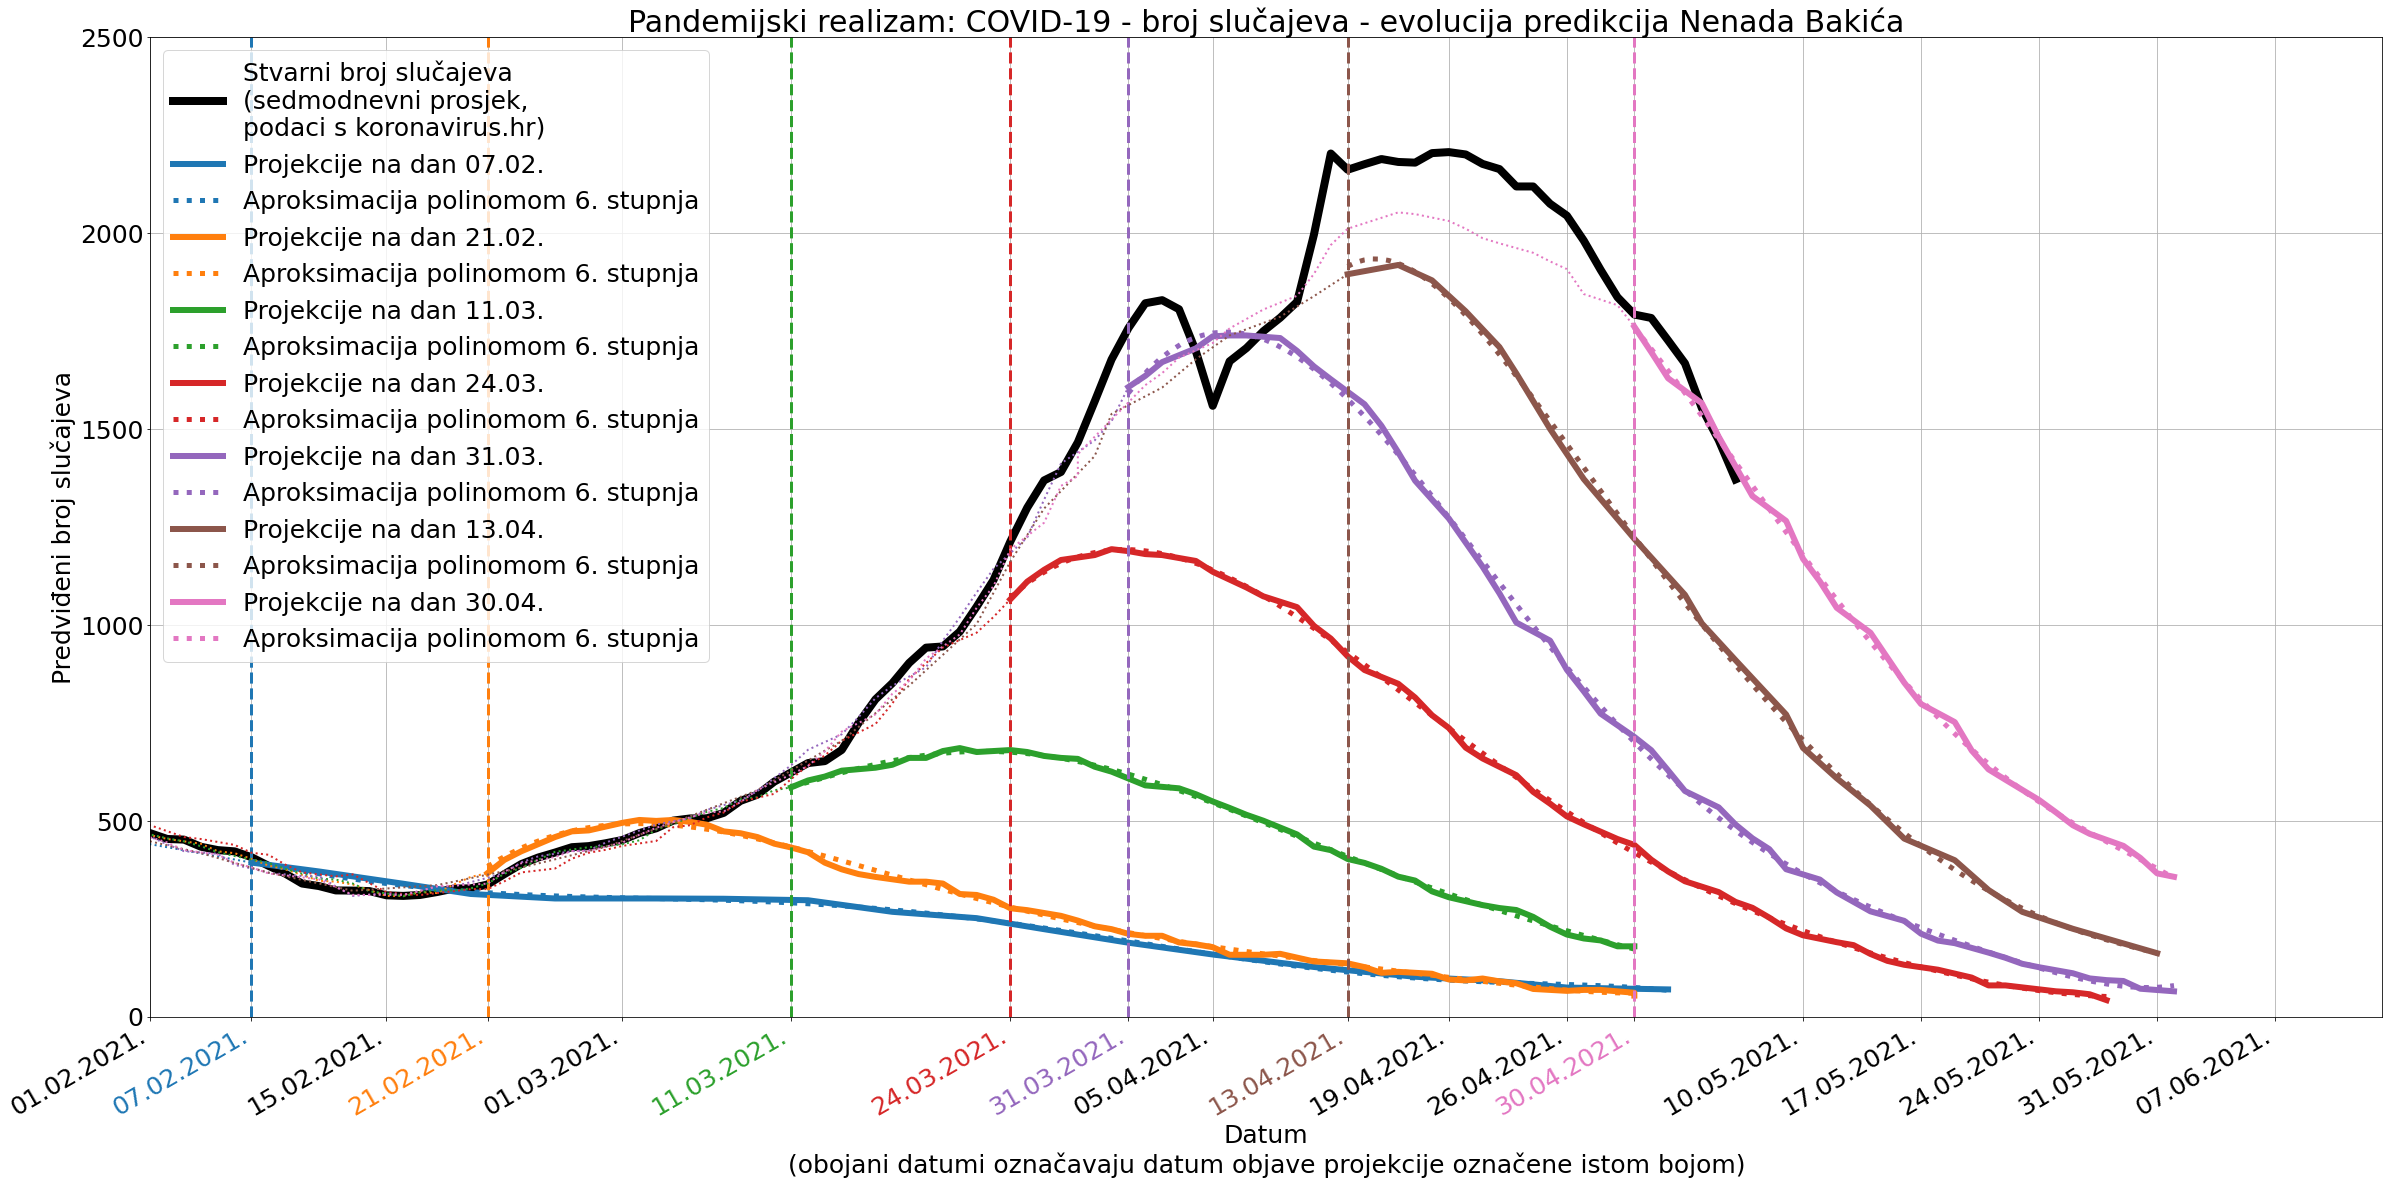

In [6]:
# plot all extracted predictions and approximations

font = {'size'  : 25}
matplotlib.rc('font', **font)

# datumi predikcija preuzeti iz objava s https://pandemijskirealizam.net/
csv_to_date = {'cases_02_08.csv' : dt.date(2021, 2, 7), 
               'cases_02_22.csv' : dt.date(2021, 2, 21),
               'cases_03_15.csv' : dt.date(2021, 3, 11),
               'cases_03_22.csv' : dt.date(2021, 3, 24),
               'cases_03_29.csv' : dt.date(2021, 3, 31),
               'cases_04_12.csv' : dt.date(2021, 4, 13),
               'cases_04_26.csv' : dt.date(2021, 4, 30) 
              }

pred_dates = []
pred_colors = {}

pred_data = {}

fig, ax = plt.subplots(1, 1, figsize=(40, 20))


all_dates_for_gt_data = [start_date + (i) * dt.timedelta(1) for i in range(0, len(gt_case_avg))]
gt_label = 'Stvarni broj slučajeva\n(sedmodnevni prosjek,\npodaci s koronavirus.hr)'

ax.plot(all_dates_for_gt_data, gt_case_avg, label=gt_label, linewidth=8, c='k')


for csv_path in csvs:    
    if 'cases' not in str(csv_path):
        continue 
    
    # read data from csv
    current_csv = read_csv(csv_path, header=None)
    
    prediction_date = csv_to_date[csv_path.name] 

    dates = current_csv[0].to_numpy()
    vals = current_csv[1].to_numpy()
    
    # convert to dates
    x = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in dates]
    
    # plot extracted predictions with a dotted line
    p = ax.plot(x, vals, linestyle=':', linewidth=2)
    

    # get dates after the prediction date, plus a few before
    filtered_dates = []
    filtered_vals = []
    
    for i, (d, v) in enumerate(zip(x, vals)):
        if prediction_date - d < dt.timedelta(days=3):
            filtered_dates.append(d)
            filtered_vals.append(v)
            
    # turn dates to numbers
    x_num = mdates.date2num(filtered_dates)
    shift = x_num.min()
    # shift to zero
    x_num -= shift

    n_deg = 6
    
    # do polyfit
    prediction_fit = np.poly1d(np.polyfit(x_num, filtered_vals, n_deg))
        
    pred_date_num = mdates.date2num(prediction_date)
    
    # x locations and dates for plotting
    xx = np.linspace(pred_date_num - shift, x_num.max(), 100)
    dd = mdates.num2date(xx + shift)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y.'))
    ax.xaxis.set_major_locator(mdates.DayLocator())

    
    only_future_dates = [d for d in x if prediction_date - d < dt.timedelta(days=1)]
    only_future_vals = [vals[i] for i, d in enumerate(x) if prediction_date - d < dt.timedelta(days=1)]
    
    pred_label = 'Projekcije na dan {}'.format(csv_to_date[csv_path.name].strftime('%d.%m.'))
    pred_colour = p[-1].get_color()
    
    ax.plot(only_future_dates, only_future_vals, label=pred_label, c=pred_colour, linewidth=6)
    
    
    pred_data[prediction_date] = (filtered_dates, filtered_vals, pred_label, pred_colour)
    
#     ax.plot(filtered_dates, filtered_vals, '+', c=p[-1].get_color(), mew=20, ms=20)

    ax.plot(dd, prediction_fit(xx), linestyle=':', c=p[-1].get_color(), linewidth=5, label='Aproksimacija polinomom {}. stupnja'.format(n_deg))
    
    
    ax.axvline(x=prediction_date, c=p[-1].get_color(), linestyle='--', linewidth=3)

    pred_dates.append(prediction_date)
    pred_colors[prediction_date.strftime('%Y-%m-%d')] = p[-1].get_color()
    

    fig.autofmt_xdate()
    

# dates of predictions
plot_dates = [x for x in pred_dates]

# additional dates for x axis
for i in range(19):
    new_date = start_date +  i * dt.timedelta(days=7)

    add = True

    for j in range(-4, 4):
        if new_date + j * dt.timedelta(1) in plot_dates:
            add = False
            break
    if add:
        plot_dates.append(new_date)

# for animation        
pred_data[start_date] = (all_dates_for_gt_data, gt_case_avg, 'gt', 'k')
    
ax.set_xticks(plot_dates)
ax.set_xticklabels(plot_dates)


plt.xlim(xmin=start_date)


new_labels = []
for x in ax.get_xticklabels():
    current_text = x.get_text()

    if current_text in pred_colors:
        x.set_color(pred_colors[current_text])

    y, m, d = current_text.split('-')

    new_labels.append('{}.{}.{}.'.format(d, m, y))

ax.set_xticklabels(new_labels)
ax.set_xlabel('Datum\n(obojani datumi označavaju datum objave projekcije označene istom bojom)')

plt.title('Pandemijski realizam: COVID-19 - broj slučajeva - evolucija predikcija Nenada Bakića')
plt.ylabel('Predviđeni broj slučajeva')
plt.ylim(bottom=0, top=2500)
plt.grid()
plt.legend()
# plt.savefig('img/aproksimacije.png', dpi=200)
plt.show()    

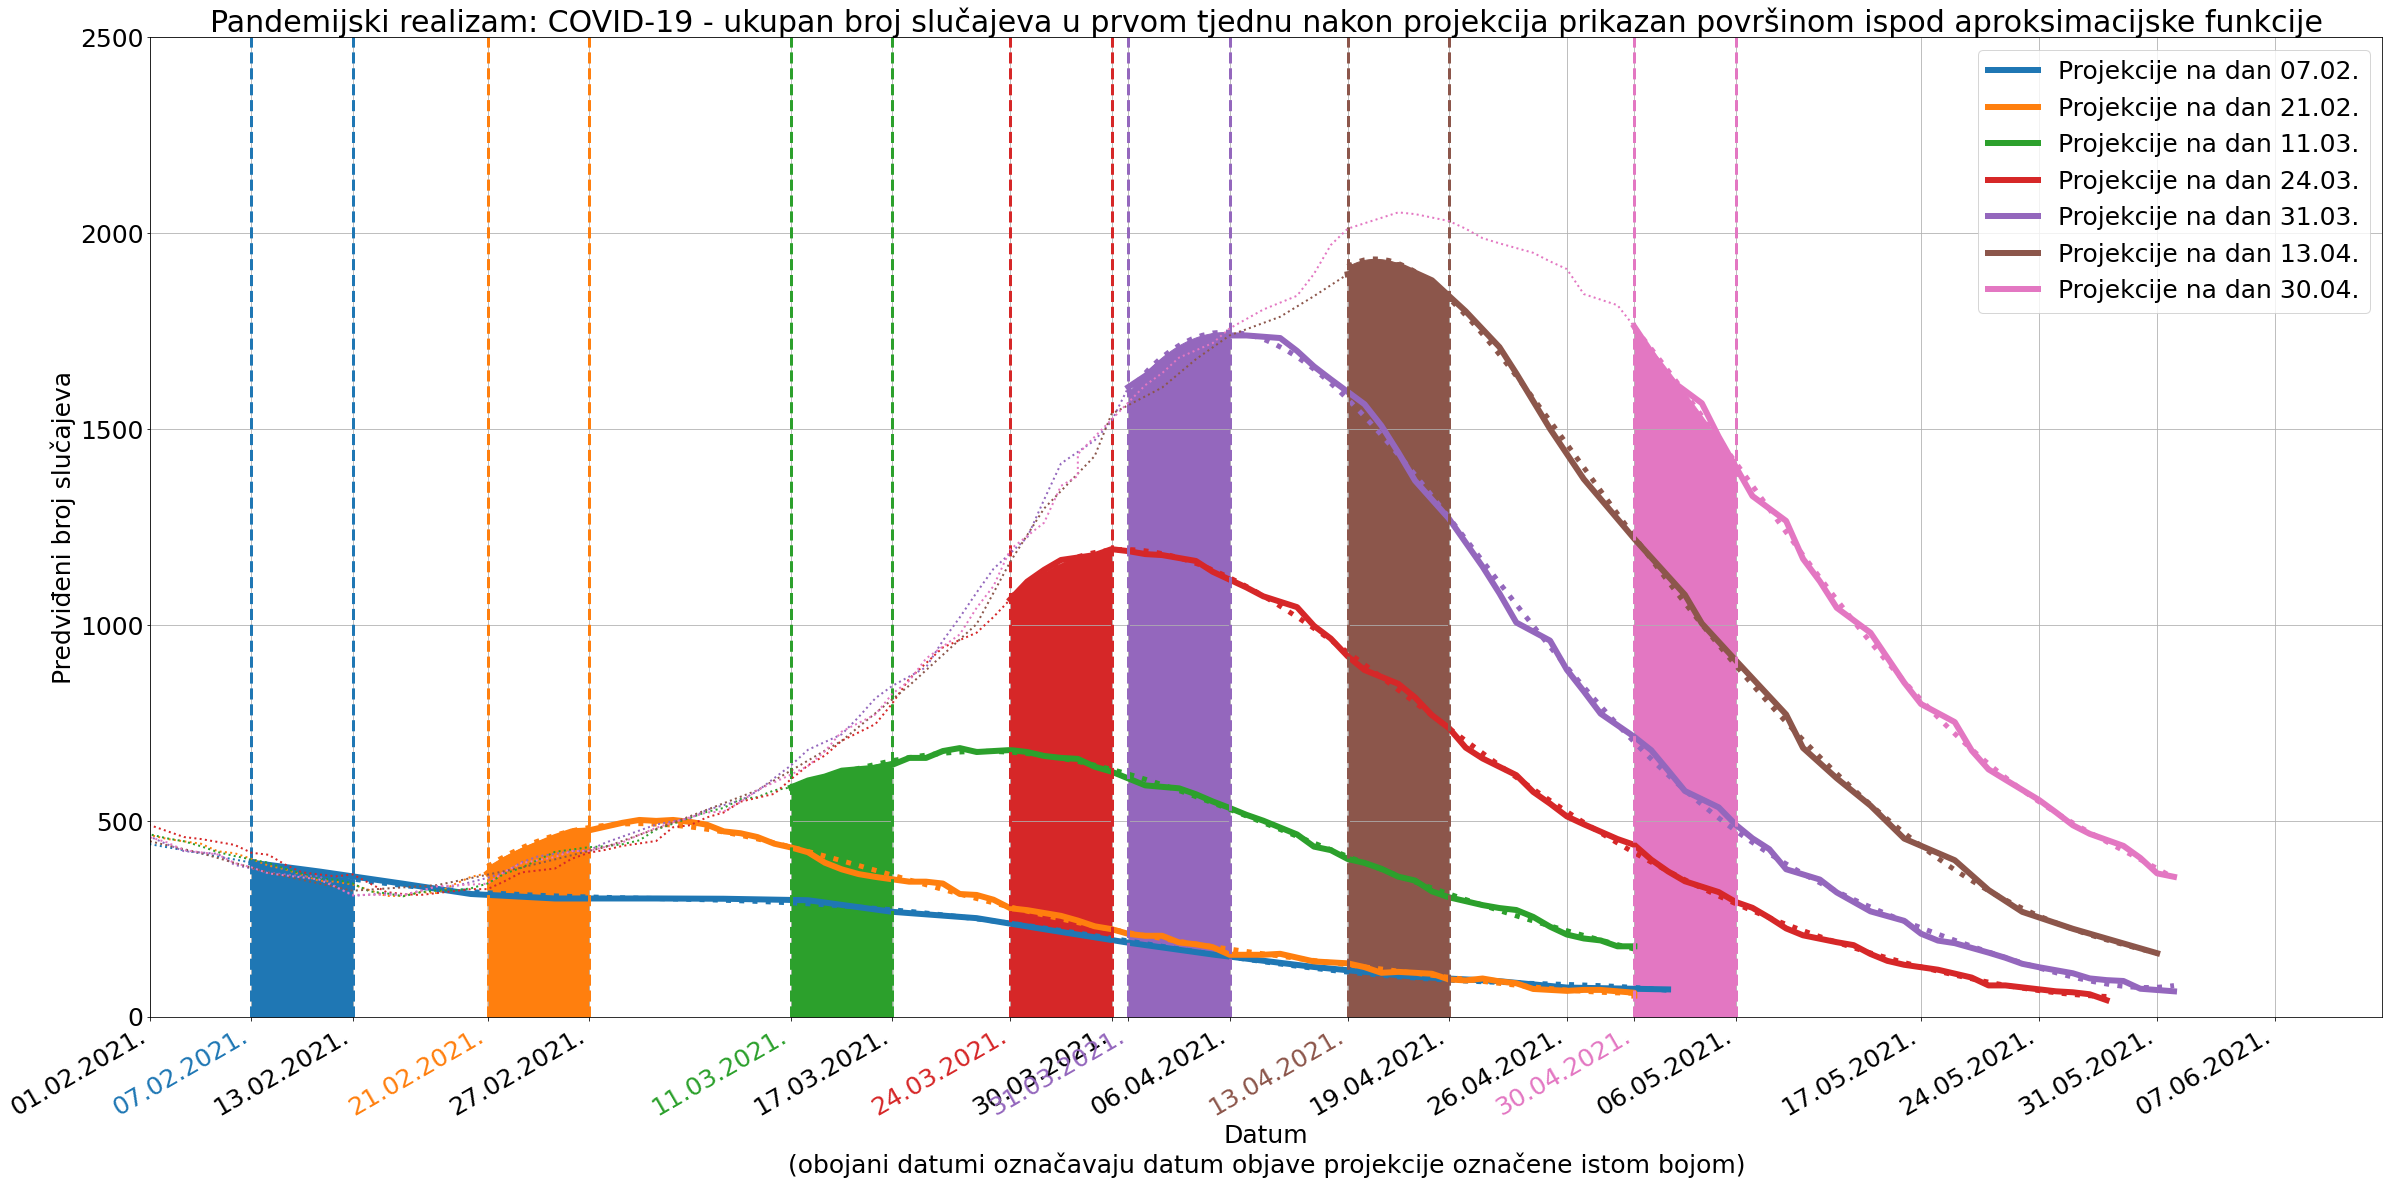

In [7]:
# plot integrals
plot_integral = True
    
pred_dates = []
pred_colors = {}

pred_data = {}

fig, ax = plt.subplots(1, 1, figsize=(40, 20))

for csv_path in csvs:    
    if 'cases' not in str(csv_path):
        continue 
    
    current_csv = read_csv(csv_path, header=None)
    
    prediction_date = csv_to_date[csv_path.name] 
    
    dates = current_csv[0].to_numpy()
    vals = current_csv[1].to_numpy()
    
    x = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in dates]

    filtered_dates = []
    filtered_vals = []
    
    for i, (d, v) in enumerate(zip(x, vals)):
        if prediction_date - d < dt.timedelta(days=3):
            filtered_dates.append(d)
            filtered_vals.append(v)
            
    
        
    x_num = mdates.date2num(filtered_dates)
    shift = x_num.min()
    x_num -= shift

    n_deg = 6
    
    prediction_fit = np.poly1d(np.polyfit(x_num, filtered_vals, n_deg))
        
    pred_date_num = mdates.date2num(prediction_date)
    
    xx = np.linspace(pred_date_num - shift, x_num.max(), 100)
    dd = mdates.num2date(xx + shift)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y.'))

    ax.xaxis.set_major_locator(mdates.DayLocator())
    p = ax.plot(x, vals, linestyle=':', linewidth=2)
    
    only_future_dates = [d for d in x if prediction_date - d < dt.timedelta(days=1)]
    only_future_vals = [vals[i] for i, d in enumerate(x) if prediction_date - d < dt.timedelta(days=1)]
    
    pred_label = 'Projekcije na dan {}'.format(csv_to_date[csv_path.name].strftime('%d.%m.'))
    pred_colour = p[-1].get_color()
    
    ax.plot(only_future_dates, only_future_vals, label=pred_label, c=pred_colour, linewidth=6)
    
    
    pred_data[prediction_date] = (filtered_dates, filtered_vals, pred_label, pred_colour)
    
#     ax.plot(filtered_dates, filtered_vals, '+', c=p[-1].get_color(), mew=20, ms=20)

    ax.plot(dd, prediction_fit(xx), linestyle=':', c=pred_colour, linewidth=5) # , label='Aproksimacija polinomom {}. stupnja'.format(n_deg))        

    ax.axvline(x=prediction_date, c=p[-1].get_color(), linestyle='--', linewidth=3)

    
    if plot_integral:
        one_week_xx = np.linspace(pred_date_num - shift, pred_date_num - shift + 6, 100)
        one_week_dd = mdates.num2date(one_week_xx + shift)

        ax.fill_between(one_week_dd, prediction_fit(one_week_xx), color=pred_colour)

        
        ax.axvline(x=prediction_date + dt.timedelta(days=6), c=p[-1].get_color(), linestyle='--', linewidth=3)
        pred_dates.append(prediction_date + dt.timedelta(days=6))
    
    
#         A 1 week ahead case forecast submitted on Monday 4th January 2021 should cover the seven 
#         days including Sunday 3rd January to Saturday 9th January. 
#         In this example, the forecast file would include:
#         forecast_date = "2021-01-04"
#         target = "1 wk ahead inc case"
#         target_end_date = "2021-01-09"

    
    pred_dates.append(prediction_date)
    pred_colors[prediction_date.strftime('%Y-%m-%d')] = p[-1].get_color()
    

    fig.autofmt_xdate()
    

################
plot_dates = [x for x in pred_dates]

for i in range(19):
    new_date = start_date +  i * dt.timedelta(days=7)

    add = True

    for j in range(-4, 4):
        if new_date + j * dt.timedelta(1) in plot_dates:
            add = False
            break
    if add:
        plot_dates.append(new_date)

all_dates_for_gt_data = [start_date + (i) * dt.timedelta(1) for i in range(0, len(gt_case_avg))]
gt_label = 'Stvarni broj slučajeva\n(sedmodnevni prosjek,\npodaci s koronavirus.hr)'

# ax.plot(all_dates_for_gt_data, gt_case_avg, label=gt_label, linewidth=8, c='k')
        
pred_data[start_date] = (all_dates_for_gt_data, gt_case_avg, 'gt', 'k')
    
ax.set_xticks(plot_dates)
ax.set_xticklabels(plot_dates)


plt.xlim(xmin=start_date)


new_labels = []
for x in ax.get_xticklabels():
    current_text = x.get_text()

    if current_text in pred_colors:
        x.set_color(pred_colors[current_text])

    y, m, d = current_text.split('-')

#     x.set_text('{}.{}.'.format(d, m))
    new_labels.append('{}.{}.{}.'.format(d, m, y))

ax.set_xticklabels(new_labels)
ax.set_xlabel('Datum\n(obojani datumi označavaju datum objave projekcije označene istom bojom)')


plt.title('Pandemijski realizam: COVID-19 - ukupan broj slučajeva u prvom tjednu nakon projekcija prikazan površinom ispod aproksimacijske funkcije')
plt.ylabel('Predviđeni broj slučajeva')
plt.ylim(bottom=0, top=2500)
plt.grid()
plt.legend()
# plt.savefig('img/integrali.png', dpi=200)
plt.show()

In [9]:
# save frames for timelapse

# timelapse_dates = [start_date + (i) * dt.timedelta(1) for i in range(0, len(gt_case_avg))]

# print(timelapse_dates[0])
# print(timelapse_dates[-1])

# how_many_to_plot = {}

# max_plotted_date = None

# for current_index, current_date in enumerate(timelapse_dates):
#     fig, ax = plt.subplots(1, 1, figsize=(40, 20))

#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y.'))
#     ax.xaxis.set_major_locator(mdates.DayLocator())
    
#     print(current_date)
    
#     if current_index == 0:
#         max_plotted_date = current_date
    
#     for prediction_date, current_data in pred_data.items():
#         if prediction_date <= current_date:
#             current_dates_to_plot = []
#             current_vals_to_plot = []
            
#             current_prediction_dates, current_prediction_vals, label, colour = current_data
            
#             if label not in how_many_to_plot:
#                 how_many_to_plot[label] = 1
            
#             if label == 'gt':
#                 current_dates_to_plot = current_prediction_dates[:how_many_to_plot[label]]
#                 current_vals_to_plot = current_prediction_vals[:how_many_to_plot[label]]
#             else:
#                 current_dates_to_plot, current_vals_to_plot = [], []
                
#                 for date, val in zip(current_prediction_dates, current_prediction_vals):
#                     if date < prediction_date + dt.timedelta(5) * how_many_to_plot[label]:
#                         current_dates_to_plot.append(date)
#                         current_vals_to_plot.append(val)

#             how_many_to_plot[label] += 1
            
#             print('would plot verical at {}'.format(prediction_date))
#             print('would plot {} data points from {} ({})'.format(len(current_vals_to_plot), prediction_date, label))
#             print('last at {}'.format(current_dates_to_plot[-1]))
    
#             if label == 'gt':
#                 ax.plot(current_dates_to_plot, current_vals_to_plot, label=gt_label, c=colour, linewidth=8)
#             else:
#                 ax.plot(current_dates_to_plot, current_vals_to_plot, label=label, c=colour, linewidth=6)
#                 ax.axvline(x=prediction_date, c=colour, linestyle='--', linewidth=3)

                
#             for d in current_dates_to_plot:
#                 if d > max_plotted_date:
#                     max_plotted_date = d
    
#     filtered_plot_dates = [x for x in plot_dates if x <= max_plotted_date]
    
    
#     ax.set_xticks(filtered_plot_dates)
#     ax.set_xticklabels(filtered_plot_dates)


#     plt.xlim(xmin=start_date, xmax=dt.date(2021, 6, 14))


#     new_labels = []
#     for x in ax.get_xticklabels():
#         current_text = x.get_text()
        
#         y, m, d = current_text.split('-')
        
#         if current_text in pred_colors:
#             if dt.date(int(y), int(m), int(d)) <= current_date:
#                 x.set_color(pred_colors[current_text])

        

#     #     x.set_text('{}.{}.'.format(d, m))
#         new_labels.append('{}.{}.{}.'.format(d, m, y))

#     ax.set_xticklabels(new_labels)
#     ax.set_xlabel('Datum\n(obojani datumi označavaju datum objave projekcije označene istom bojom)')


#     plt.title('Pandemijski idealizam: COVID-19 - broj slučajeva - evolucija predikcija Nenada Bakića ({})'.format(current_date.strftime('%d.%m.%Y.')))
#     plt.ylabel('Predviđeni broj slučajeva')
#     plt.ylim(bottom=0, top=2500)
#     plt.grid()
#     plt.legend()
#     fig.autofmt_xdate()
# #     plt.show()
#     plt.tight_layout()
#     plt.savefig('img/anim_{}_{}.png'.format(str(current_index).zfill(5), current_date), dpi=200)
#     plt.clf()
#     plt.close()
    
            

published: 2021-02-07, forecast: 2021-02-08
week 1
forecast date 2021-02-08
sun to sat: 2584.7948909493625
published: 2021-02-21, forecast: 2021-02-22
week 1
forecast date 2021-02-22
sun to sat: 3144.9516649973725
published: 2021-03-11, forecast: 2021-03-15
week 1
forecast date 2021-03-15
sun to sat: 4581.545601724076
published: 2021-03-24, forecast: 2021-03-22
week 1
forecast date 2021-03-22
sun to sat: 7522.06492057629
published: 2021-03-31, forecast: 2021-03-29
week 1
forecast date 2021-03-29
sun to sat: 11174.988281552498
published: 2021-04-13, forecast: 2021-04-12
week 1
forecast date 2021-04-12
sun to sat: 13345.6396925803
published: 2021-04-30, forecast: 2021-04-26
week 1
forecast date 2021-04-26
sun to sat: 12826.760534332927


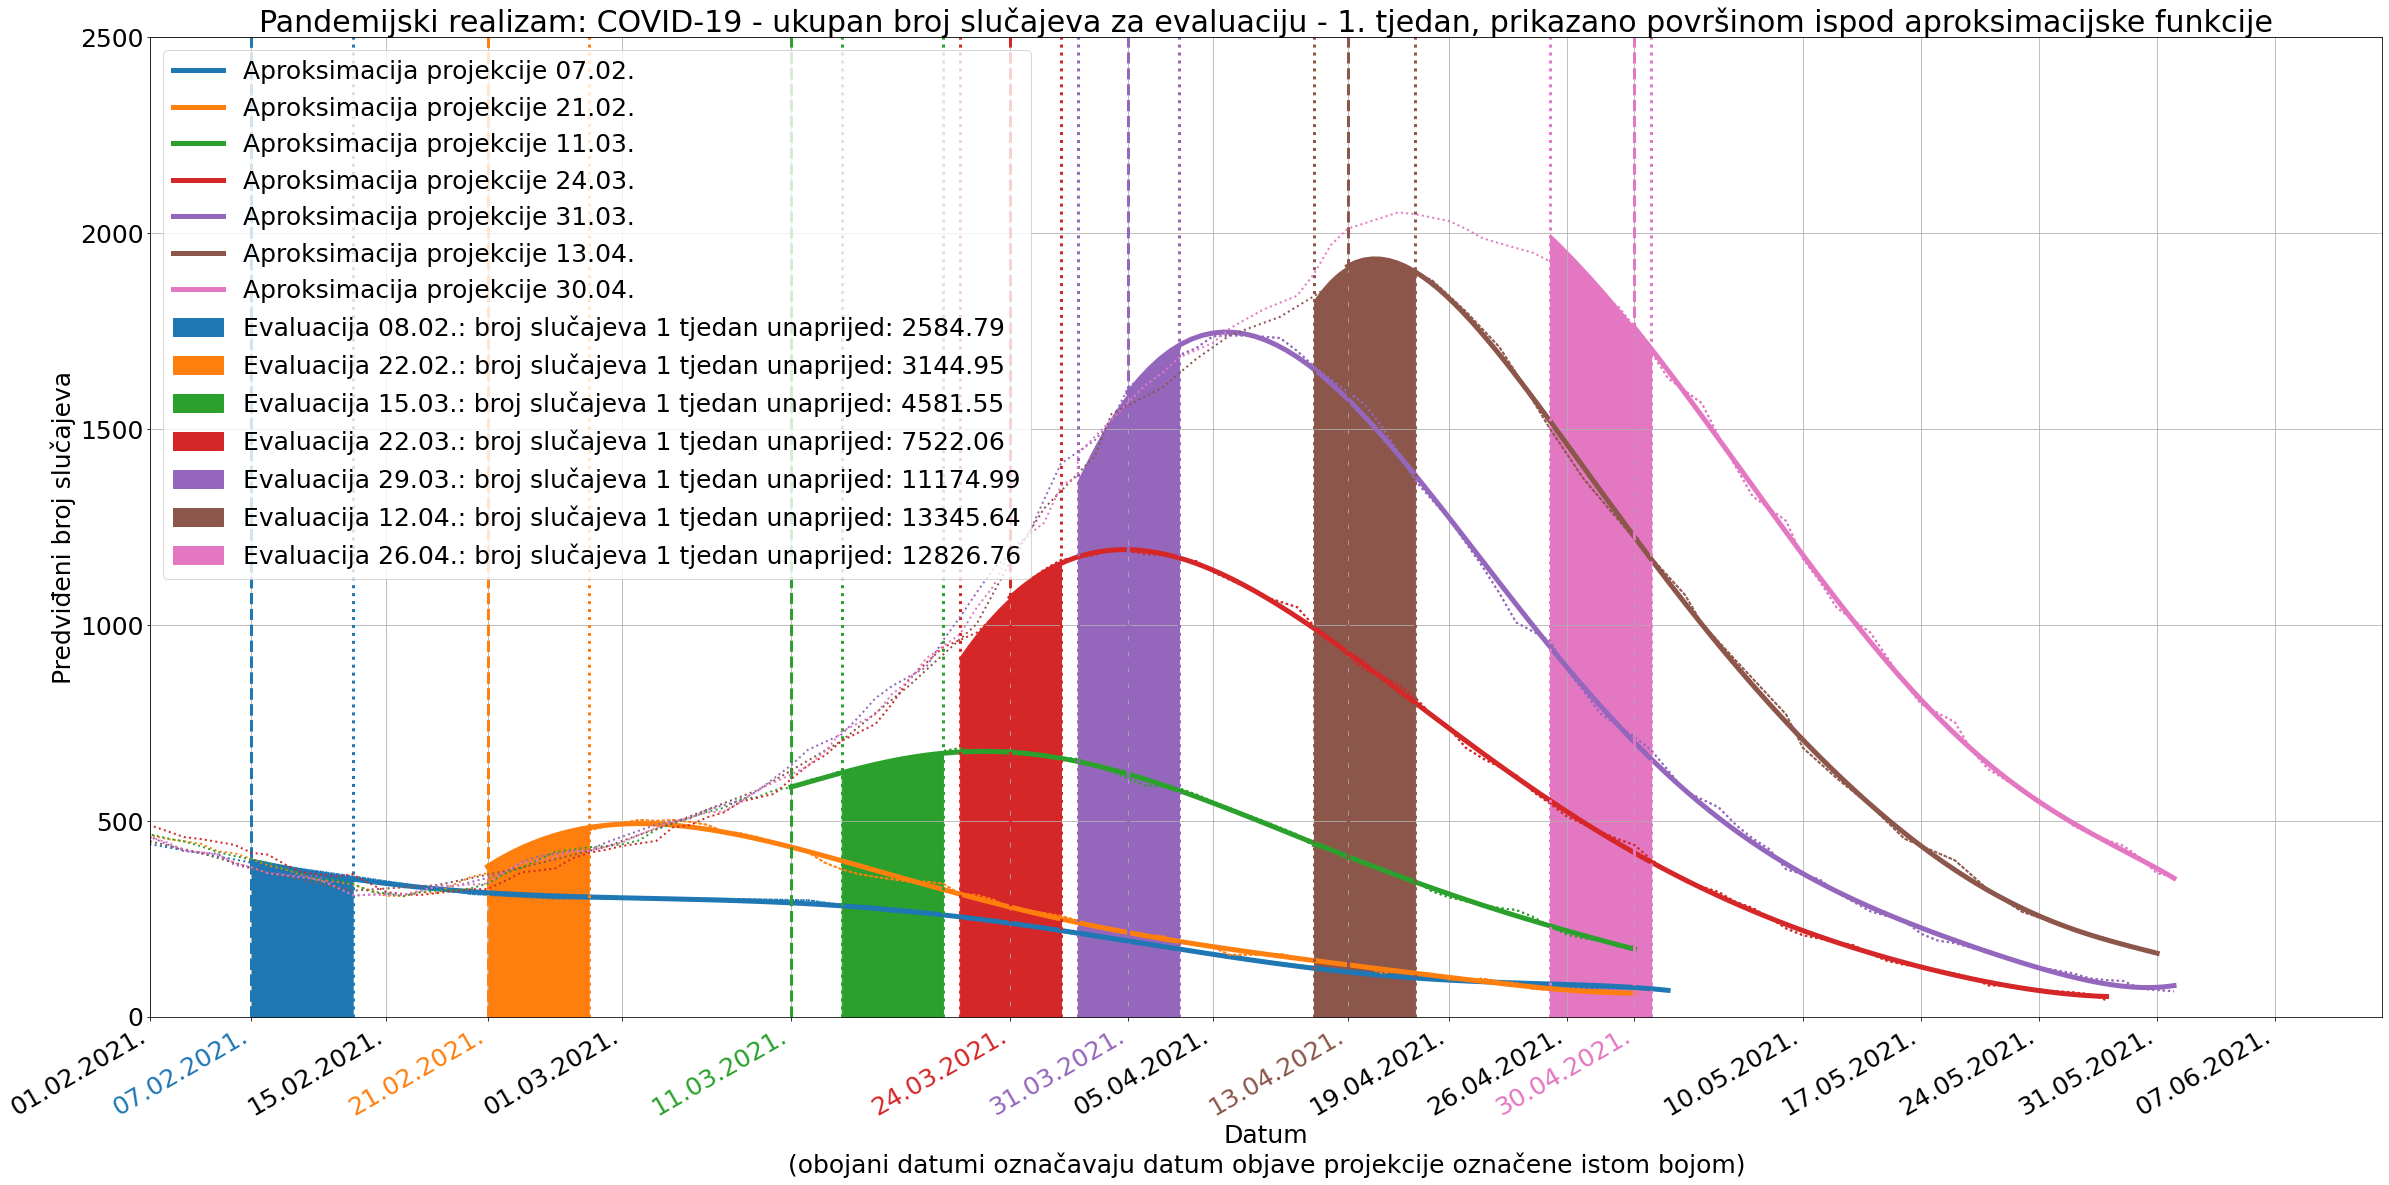

published: 2021-02-07, forecast: 2021-02-08
week 2
forecast date 2021-02-08
sun to sat: 2302.8549357049333
published: 2021-02-21, forecast: 2021-02-22
week 2
forecast date 2021-02-22
sun to sat: 3408.4923945728438
published: 2021-03-11, forecast: 2021-03-15
week 2
forecast date 2021-03-15
sun to sat: 4690.551176480357
published: 2021-03-24, forecast: 2021-03-22
week 2
forecast date 2021-03-22
sun to sat: 8278.811216881943
published: 2021-03-31, forecast: 2021-03-29
week 2
forecast date 2021-03-29
sun to sat: 12056.428947283595
published: 2021-04-13, forecast: 2021-04-12
week 2
forecast date 2021-04-12
sun to sat: 11969.564644926051
published: 2021-04-30, forecast: 2021-04-26
week 2
forecast date 2021-04-26
sun to sat: 10109.973491020059


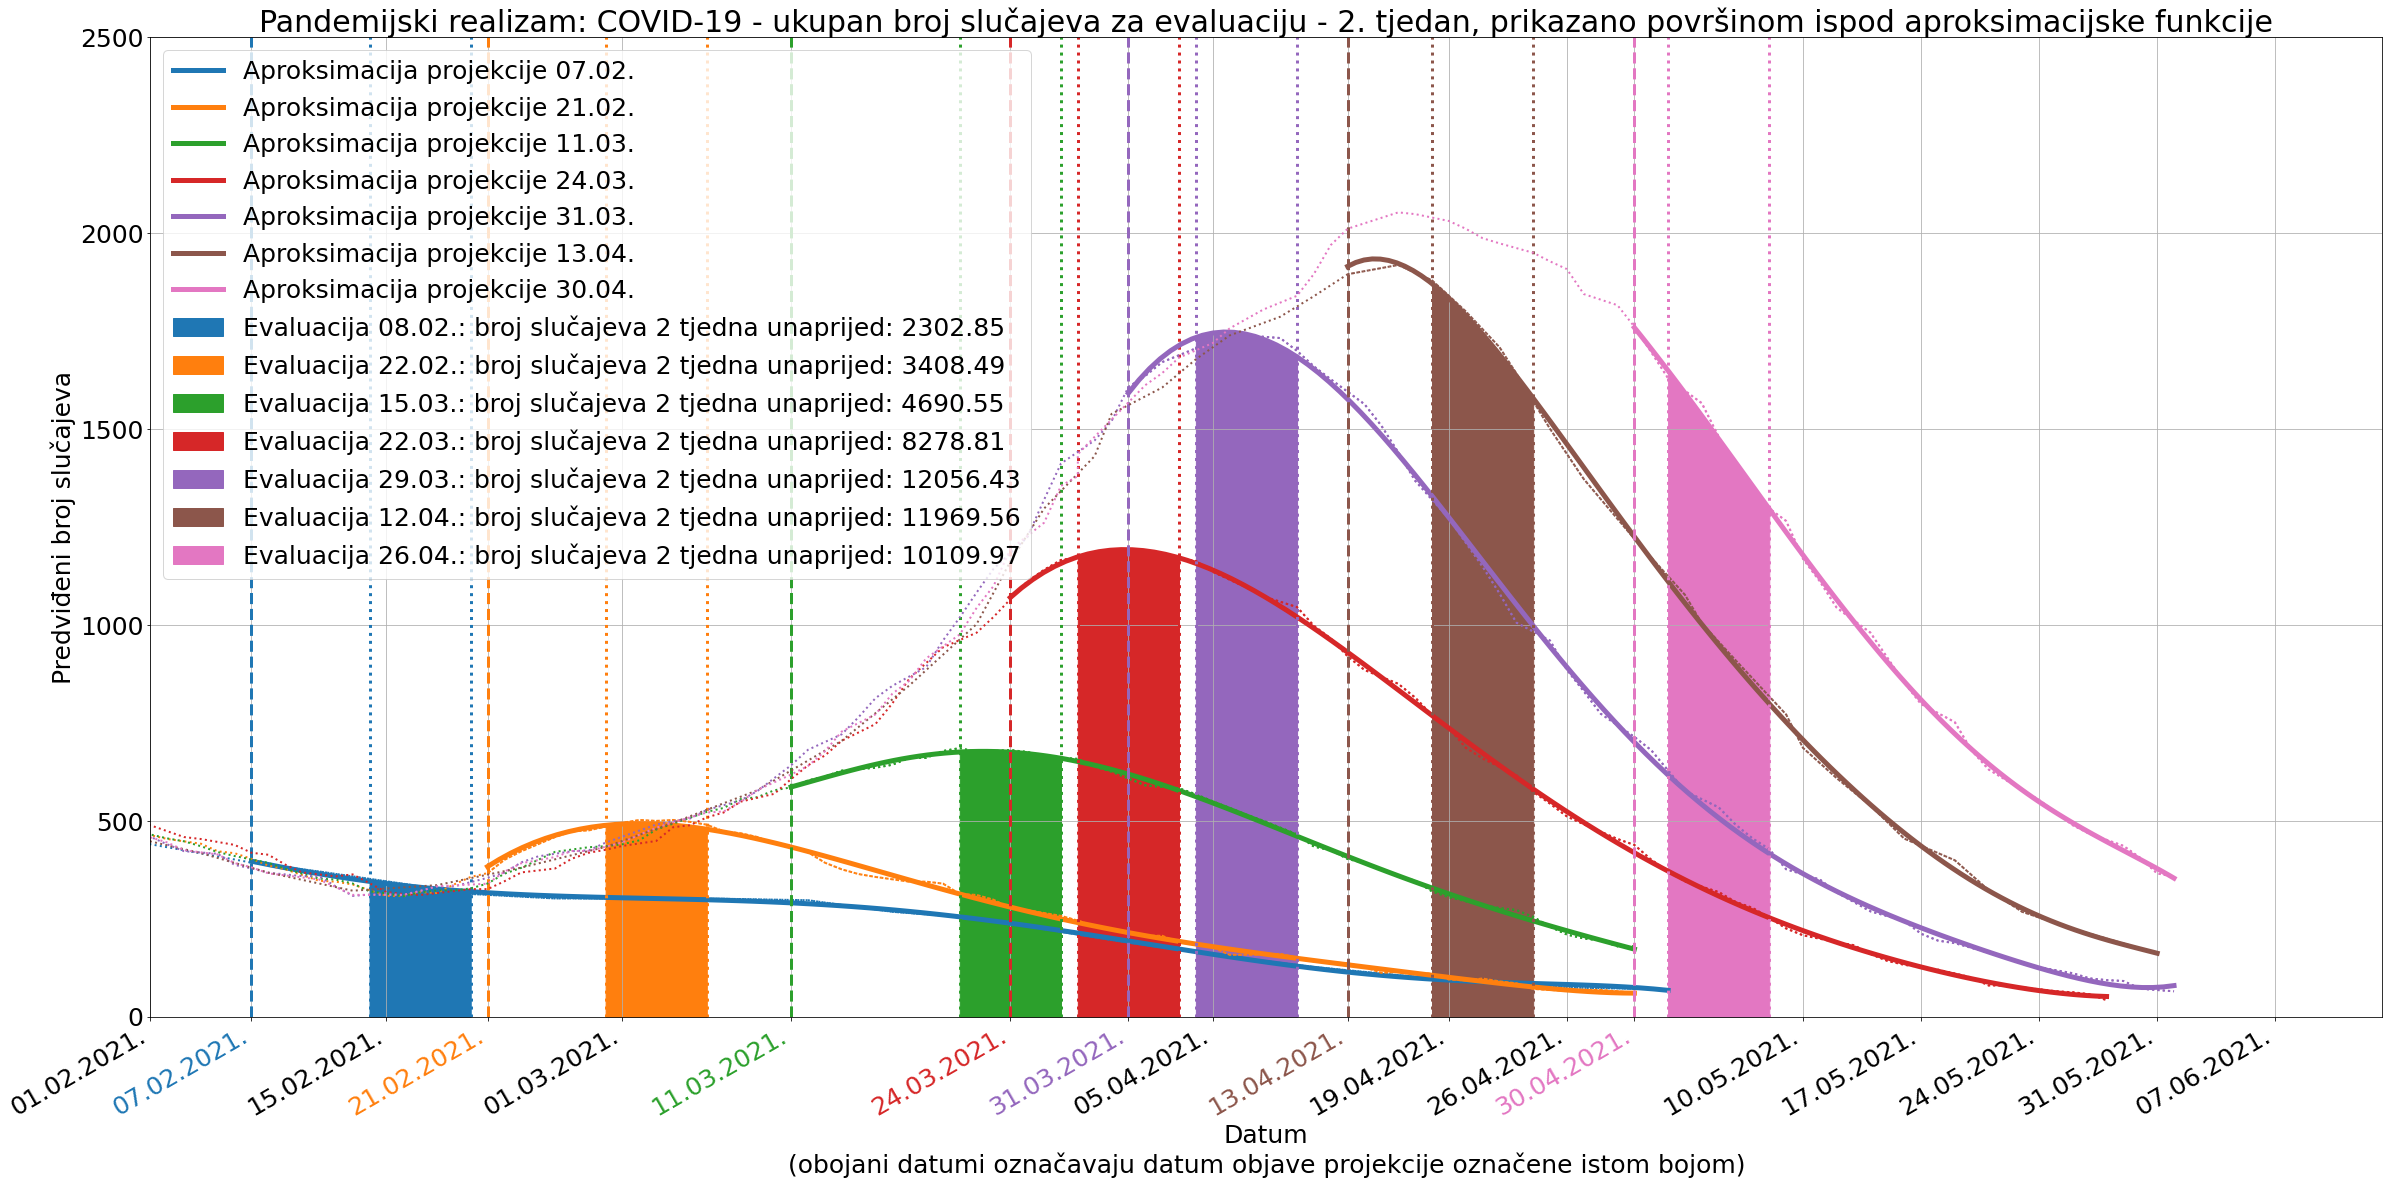

published: 2021-02-07, forecast: 2021-02-08
week 3
forecast date 2021-02-08
sun to sat: 2165.5950895255246
published: 2021-02-21, forecast: 2021-02-22
week 3
forecast date 2021-02-22
sun to sat: 3059.418111885974
published: 2021-03-11, forecast: 2021-03-15
week 3
forecast date 2021-03-15
sun to sat: 4273.810789005083
published: 2021-03-24, forecast: 2021-03-22
week 3
forecast date 2021-03-22
sun to sat: 7576.272563381122
published: 2021-03-31, forecast: 2021-03-29
week 3
forecast date 2021-03-29
sun to sat: 10521.313284314463
published: 2021-04-13, forecast: 2021-04-12
week 3
forecast date 2021-04-12
sun to sat: 9198.065914610008
published: 2021-04-30, forecast: 2021-04-26
week 3
forecast date 2021-04-26
sun to sat: 7279.905139807663


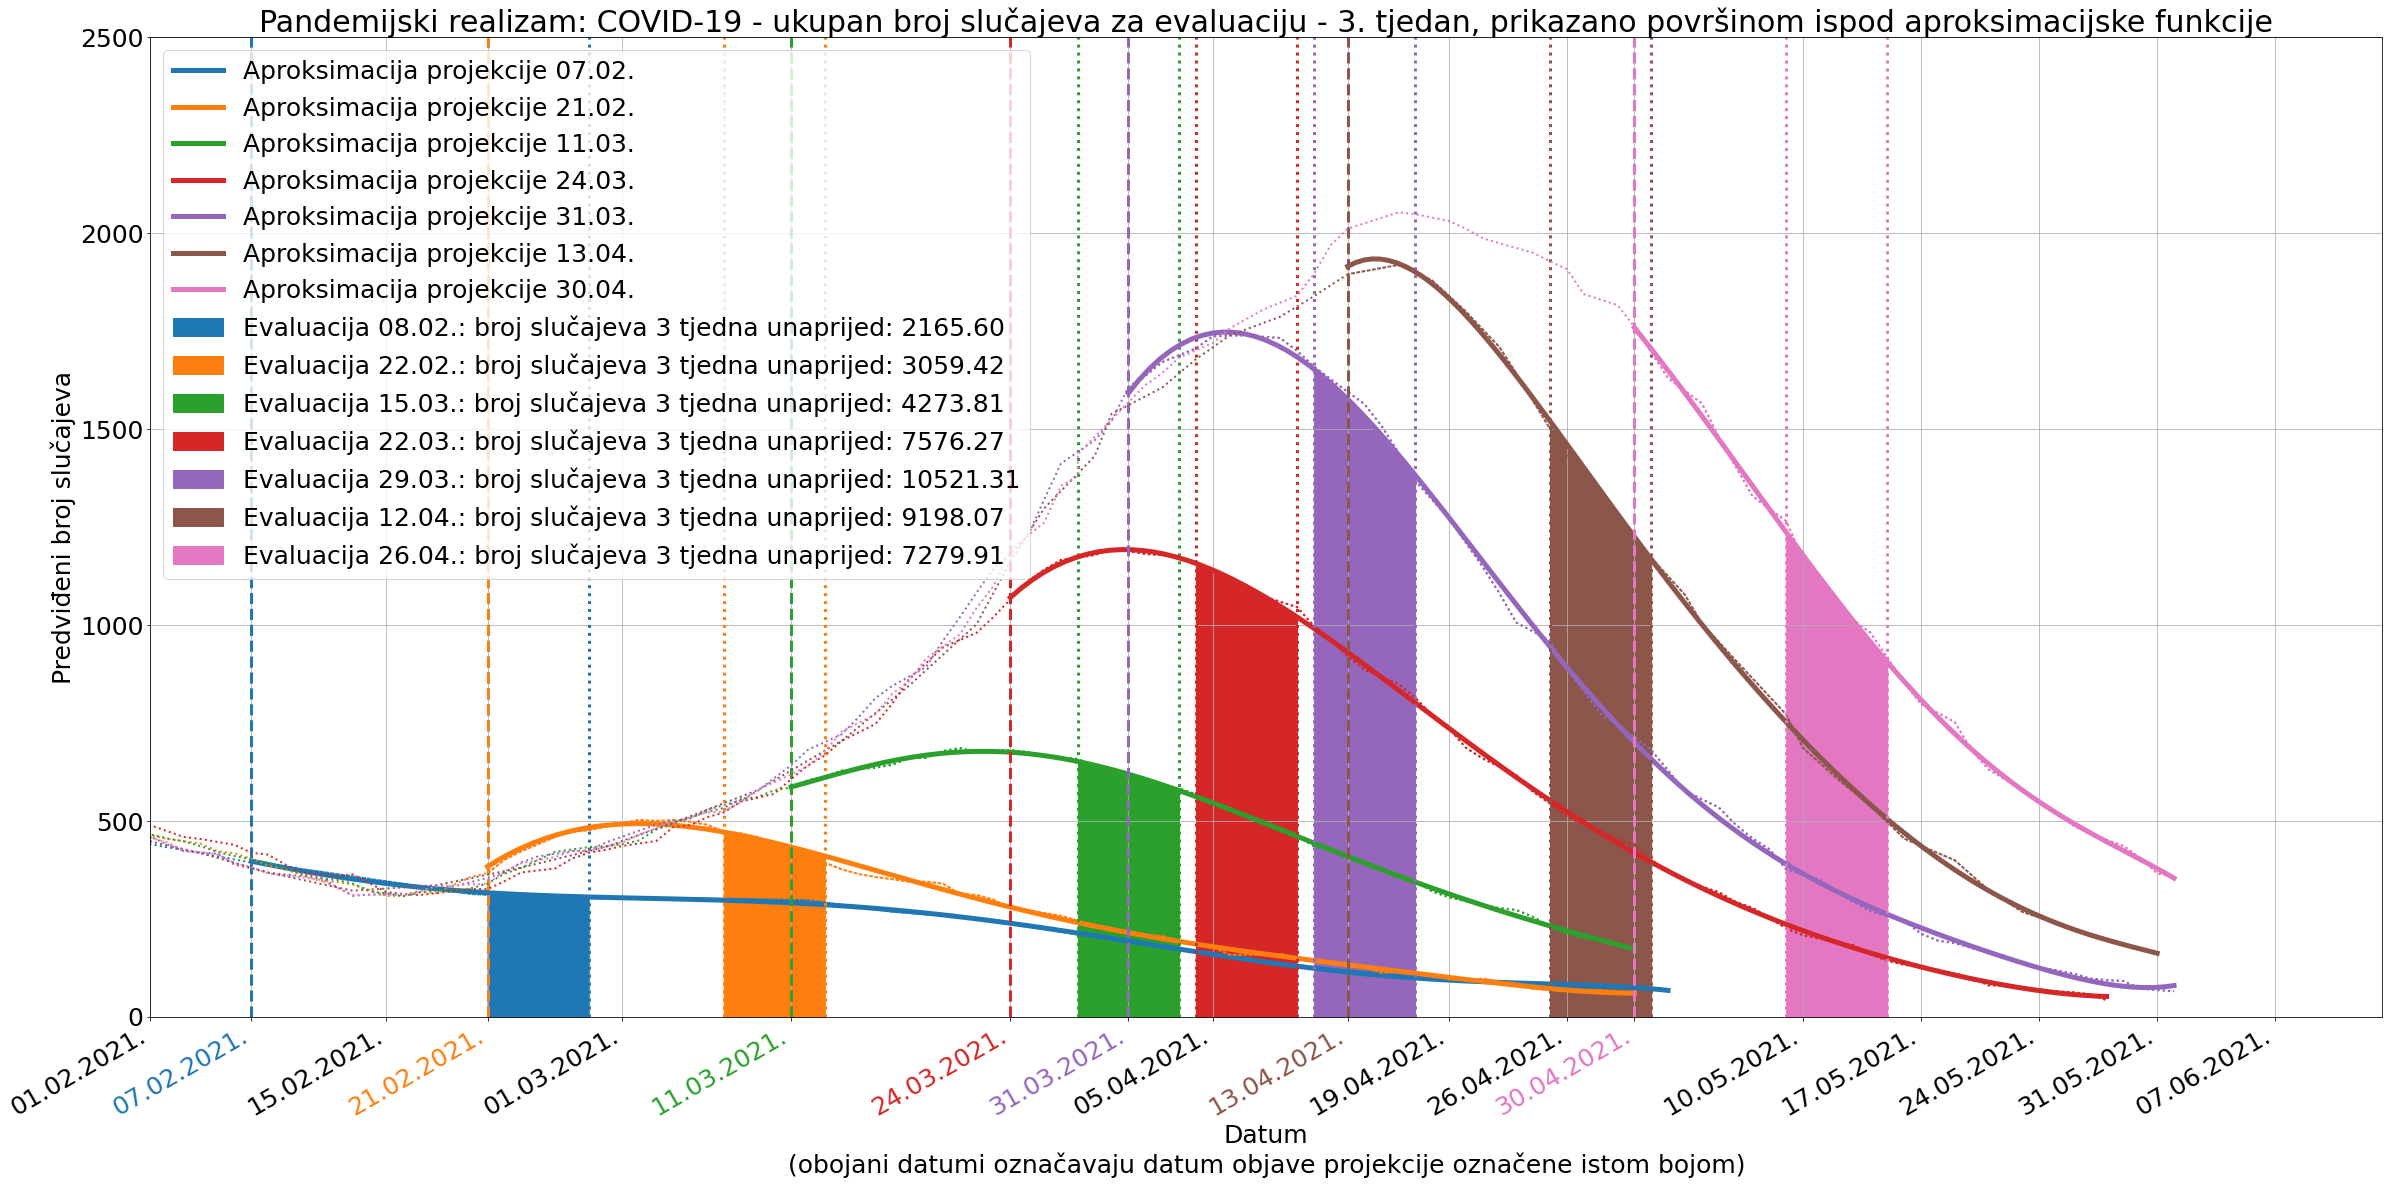

published: 2021-02-07, forecast: 2021-02-08
week 4
forecast date 2021-02-08
sun to sat: 2105.9650281423937
published: 2021-02-21, forecast: 2021-02-22
week 4
forecast date 2021-02-22
sun to sat: 2485.8735510810075
published: 2021-03-11, forecast: 2021-03-15
week 4
forecast date 2021-03-15
sun to sat: 3522.5759195422143
published: 2021-03-24, forecast: 2021-03-22
week 4
forecast date 2021-03-22
sun to sat: 6171.920034032904
published: 2021-03-31, forecast: 2021-03-29
week 4
forecast date 2021-03-29
sun to sat: 7950.533376423296
published: 2021-04-13, forecast: 2021-04-12
week 4
forecast date 2021-04-12
sun to sat: 6480.042677344769
published: 2021-04-30, forecast: 2021-04-26
week 4
forecast date 2021-04-26
sun to sat: 4949.247912061222


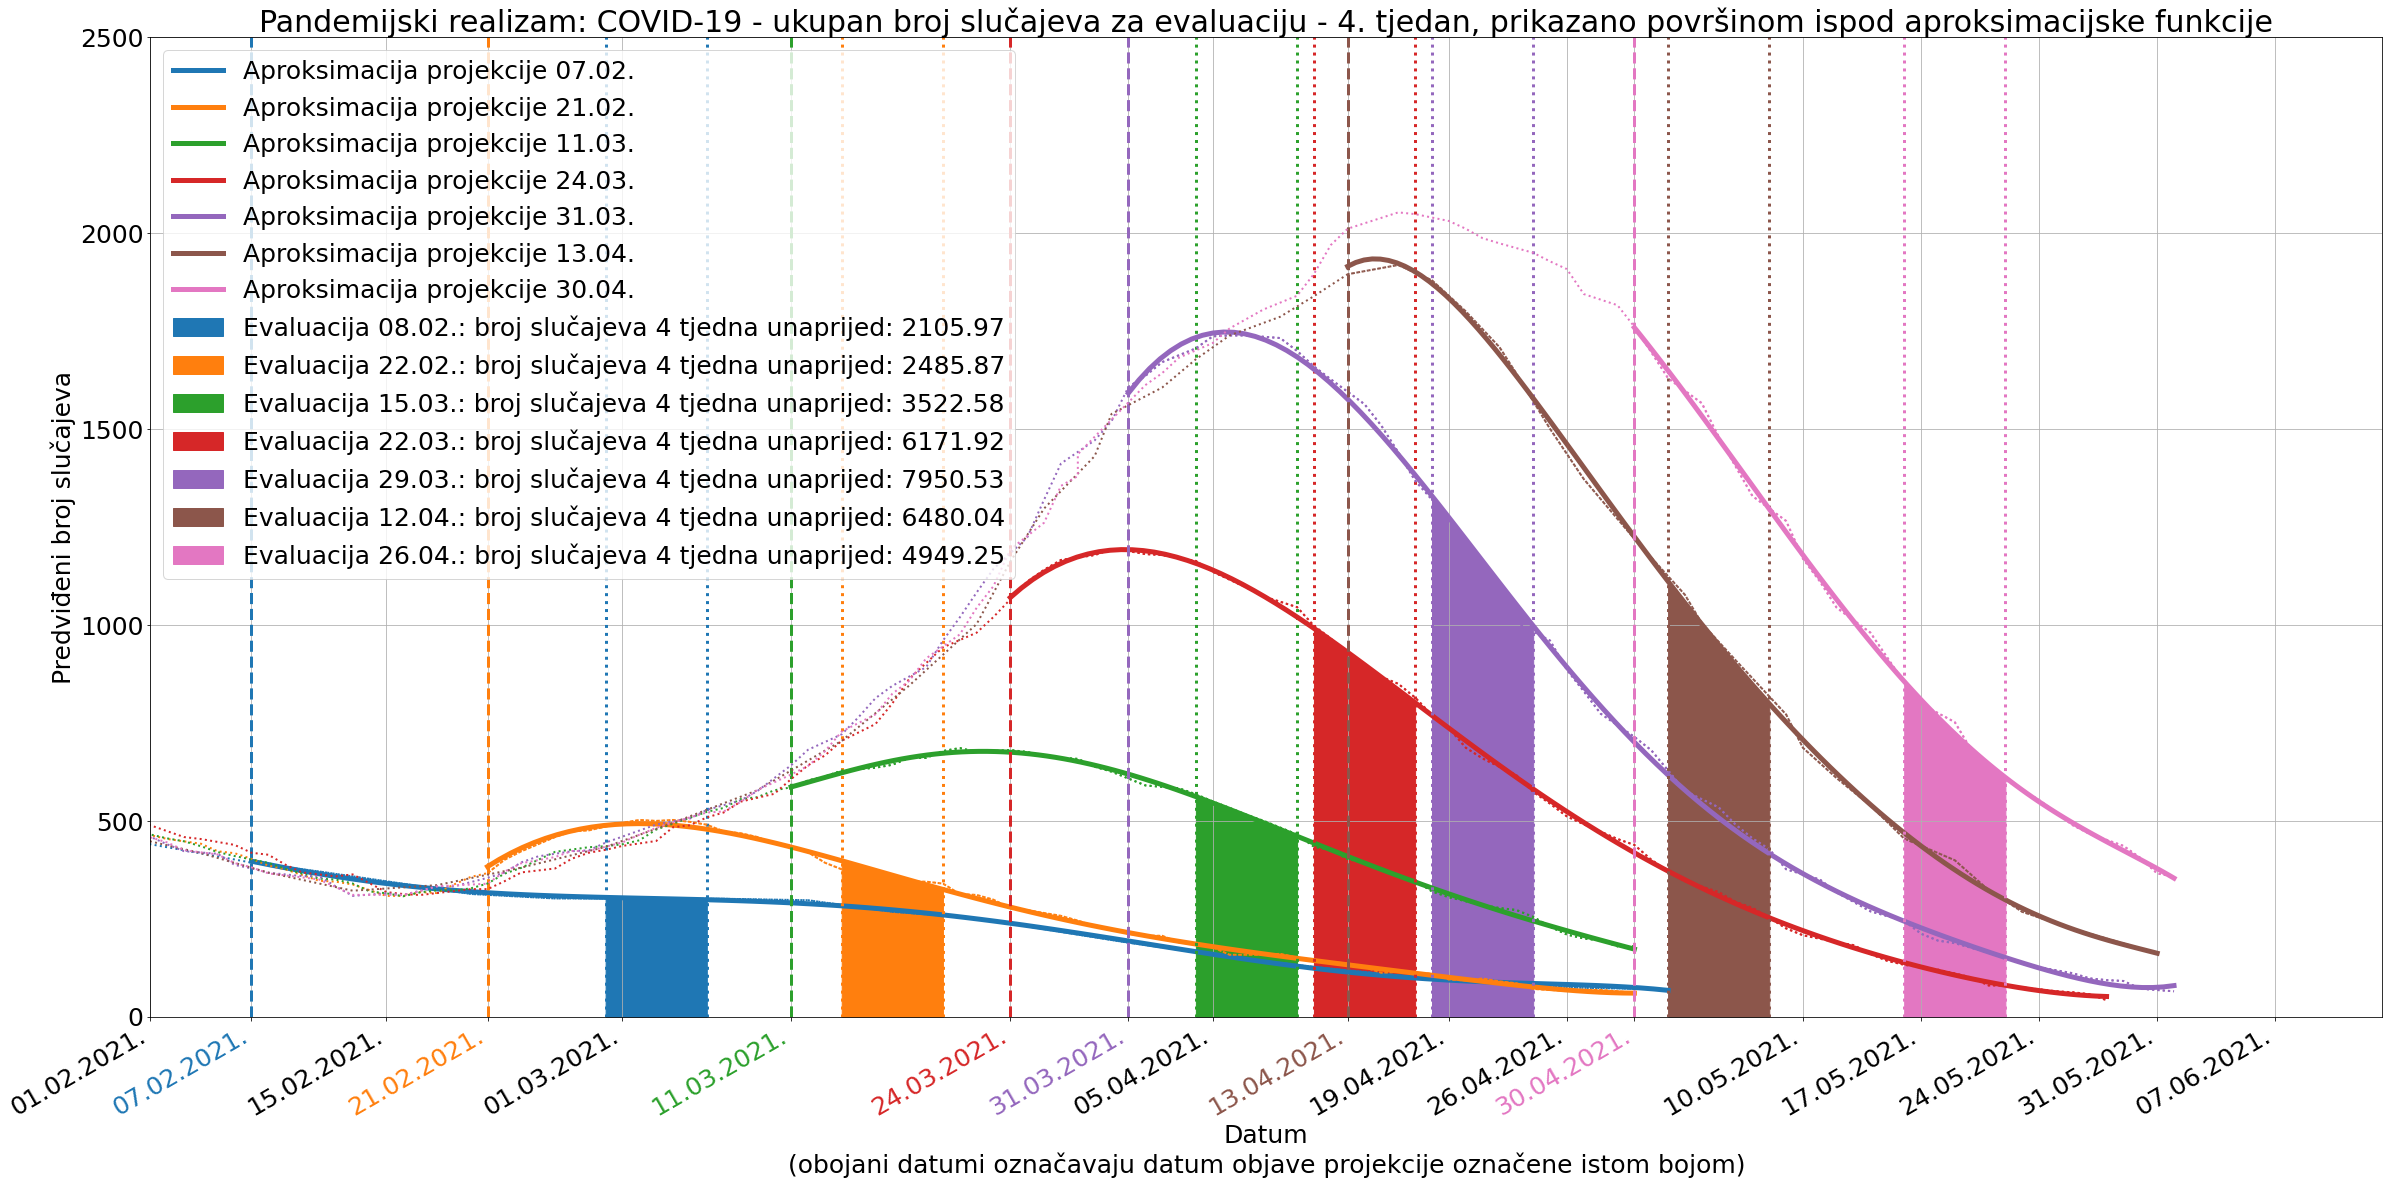

In [11]:
# get the estimated predictions and make some plots

date_published_to_forecast_date = {
        dt.date(2021, 2, 7) : dt.date(2021, 2, 8),
        dt.date(2021, 2, 21) : dt.date(2021, 2, 22) ,
        dt.date(2021, 3, 11) : dt.date(2021, 3, 15),
        dt.date(2021, 3, 24) : dt.date(2021, 3, 22),
        dt.date(2021, 3, 31) : dt.date(2021, 3, 29),
        dt.date(2021, 4, 13) : dt.date(2021, 4, 12),
        dt.date(2021, 4, 30) : dt.date(2021, 4, 26)
}

forecasts_for_eval = {}


plot_border_dates = False

for num_weeks_ahead in range(0, 4):
    pred_dates = []
    pred_colors = {}

    pred_data = {}
    
    all_dates_for_gt_data = [start_date + (i) * dt.timedelta(1) for i in range(0, len(gt_case_avg))]
    gt_label = 'Stvarni broj slučajeva\n(sedmodnevni prosjek,\npodaci s koronavirus.hr)'

    pred_data[start_date] = (all_dates_for_gt_data, gt_case_avg, 'gt', 'k')
    
    
    fig, ax = plt.subplots(1, 1, figsize=(40, 20))

    for csv_path in csvs:    
        if 'cases' not in str(csv_path):
            continue 

        current_csv = read_csv(csv_path, header=None)

        prediction_date = csv_to_date[csv_path.name] 

        forecast_date = date_published_to_forecast_date[prediction_date]

        print('published: {}, forecast: {}'.format(prediction_date, forecast_date))

        dates = current_csv[0].to_numpy()
        vals = current_csv[1].to_numpy()

        x = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in dates]

        filtered_dates = []
        filtered_vals = []

        for i, (d, v) in enumerate(zip(x, vals)):
            if prediction_date - d < dt.timedelta(days=3):
                filtered_dates.append(d)
                filtered_vals.append(v)

        x_num = mdates.date2num(filtered_dates)
        shift = x_num.min()
        x_num -= shift

        n_deg = 6

        prediction_fit = np.poly1d(np.polyfit(x_num, filtered_vals, n_deg))

        pred_date_num = mdates.date2num(prediction_date)

        xx = np.linspace(pred_date_num - shift, x_num.max(), 100)
        dd = mdates.num2date(xx + shift)


        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y.'))

        ax.xaxis.set_major_locator(mdates.DayLocator())
        p = ax.plot(x, vals, linestyle=':', linewidth=2)

        only_future_dates = [d for d in x if prediction_date - d < dt.timedelta(days=1)]
        only_future_vals = [vals[i] for i, d in enumerate(x) if prediction_date - d < dt.timedelta(days=1)]

        pred_label = 'Projekcije na dan {}'.format(prediction_date.strftime('%d.%m.'))
        pred_colour = p[-1].get_color()

        ax.plot(only_future_dates, only_future_vals, c=pred_colour, linewidth=2, linestyle=':') # label=pred_label


        pred_data[prediction_date] = (filtered_dates, filtered_vals, pred_label, pred_colour)

    #     ax.plot(filtered_dates, filtered_vals, '+', c=p[-1].get_color(), mew=20, ms=20)
        ax.axvline(x=prediction_date, c=p[-1].get_color(), linestyle='--', linewidth=3)

        

        # forecasts should be submitted on Mondays

        # Sunday - start of week
        sunday = forecast_date - dt.timedelta(days=1) + num_weeks_ahead * dt.timedelta(days=7)
        # Saturday - end of week
        saturday = forecast_date + dt.timedelta(days=5) + num_weeks_ahead * dt.timedelta(days=7)

        # date to number
        sunday_day_num = mdates.date2num(sunday)
        saturday_day_num = mdates.date2num(saturday)

        # calculate integral
        integ = prediction_fit.integ()

        print('week {}'.format(num_weeks_ahead + 1))
        print('forecast date {}'.format(forecast_date))
        total_cases = integ(saturday_day_num - shift + 1) - integ(sunday_day_num - shift)

        print('sun to sat:', total_cases)

        one_week_xx = np.linspace(sunday_day_num - shift, saturday_day_num - shift, 100)
        one_week_dd = mdates.num2date(one_week_xx + shift)

        if num_weeks_ahead == 0:
            week = 'tjedan'
        else:
            week = 'tjedna'

        label ='Evaluacija {}: broj slučajeva {} {} unaprijed: {:.2f}'.format(forecast_date.strftime('%d.%m.'), num_weeks_ahead + 1,  week, total_cases)

        # fill area under function
        ax.fill_between(one_week_dd, prediction_fit(one_week_xx), color=pred_colour, label=label)

        # mark borders
        ax.axvline(x=sunday, c=p[-1].get_color(), linestyle=':', linewidth=3)
        ax.axvline(x=saturday, c=p[-1].get_color(), linestyle=':', linewidth=3)

        # add dates to display
        if plot_border_dates:
            pred_dates.append(sunday)
            pred_dates.append(saturday)

        # store predictions
        if forecast_date not in forecasts_for_eval:
            forecasts_for_eval[forecast_date] = []

        forecasts_for_eval[forecast_date].append(total_cases)

    
        ax.plot(dd, prediction_fit(xx), c=pred_colour, linewidth=5, label='Aproksimacija projekcije {}'.format(prediction_date.strftime('%d.%m.')))
        
    # todo? plot error
    #         err = prediction_fit * np.poly1d([1, 0])

    #         ax.plot(dd, prediction_fit(xx) + 0.05 * err(xx), linestyle=':', c=pred_colour, linewidth=3)
    #         ax.plot(dd, prediction_fit(xx) - 0.05 * err(xx), linestyle=':', c=pred_colour, linewidth=3)

    #         ax.fill_between(dd, prediction_fit(xx) + 0.05 * err(xx), prediction_fit(xx) - 0.05 * err(xx), color=pred_colour, alpha=0.1)
        
    #         A 1 week ahead case forecast submitted on Monday 4th January 2021 should cover the seven 
    #         days including Sunday 3rd January to Saturday 9th January. 
    #         In this example, the forecast file would include:
    #         forecast_date = "2021-01-04"
    #         target = "1 wk ahead inc case"
    #         target_end_date = "2021-01-09"

        pred_dates.append(prediction_date)
        pred_colors[prediction_date.strftime('%Y-%m-%d')] = p[-1].get_color()


        fig.autofmt_xdate()


    ################
    plot_dates = [x for x in pred_dates]

    for i in range(19):
        new_date = start_date +  i * dt.timedelta(days=7)

        add = True
        
        for j in range(-4, 4):
            if new_date + j * dt.timedelta(1) in plot_dates:
                add = False
                break
        if add:
            plot_dates.append(new_date)

    

    ax.set_xticks(plot_dates)
    ax.set_xticklabels(plot_dates)


    plt.xlim(xmin=start_date)


    new_labels = []
    for x in ax.get_xticklabels():
        current_text = x.get_text()

        if current_text in pred_colors:
            x.set_color(pred_colors[current_text])

        y, m, d = current_text.split('-')

        new_labels.append('{}.{}.{}.'.format(d, m, y))

    ax.set_xticklabels(new_labels)
    ax.set_xlabel('Datum\n(obojani datumi označavaju datum objave projekcije označene istom bojom)')


    plt.title('Pandemijski realizam: COVID-19 - ukupan broj slučajeva za evaluaciju - {}. tjedan, prikazano površinom ispod aproksimacijske funkcije'.format(num_weeks_ahead + 1))
    plt.ylabel('Predviđeni broj slučajeva')
    plt.ylim(bottom=0, top=2500)
    plt.grid()
    plt.legend()
    plt.savefig('img/predikcija_{}.png'.format(num_weeks_ahead + 1), dpi=200)
    plt.show()

In [12]:
for eval_date, predictions_per_week in forecasts_for_eval.items():
    print(eval_date)
    print(['{:.2f}'.format(x) for x in predictions_per_week])

2021-02-08
['2584.79', '2302.85', '2165.60', '2105.97']
2021-02-22
['3144.95', '3408.49', '3059.42', '2485.87']
2021-03-15
['4581.55', '4690.55', '4273.81', '3522.58']
2021-03-22
['7522.06', '8278.81', '7576.27', '6171.92']
2021-03-29
['11174.99', '12056.43', '10521.31', '7950.53']
2021-04-12
['13345.64', '11969.56', '9198.07', '6480.04']
2021-04-26
['12826.76', '10109.97', '7279.91', '4949.25']


In [20]:
# forecast_date
# target  "# wk ahead inc case"
# target_end_date
# location
# type "point"
# value
from scipy.stats import norm
import csv

quantiles = [0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.950, 0.975, 0.990]

keys = ['location', 'target', 'type', 'quantile', 
        'value', 'forecast_date', 'target_end_date']


for eval_date, predictions_per_week in forecasts_for_eval.items():   
    print('{}-bakic-model.csv'.format(eval_date))
    with open('data-processed/bakic-model/{}-bakic-model.csv'.format(eval_date), 'w') as f: 

        w = csv.DictWriter(f, keys)
        
        w.writeheader()
        
        for pred_index, current_prediction in enumerate(predictions_per_week):
            
            if eval_date == dt.date(2021, 4, 26) and pred_index == 0:
                # skip prediction
                continue #  '26.04.2021.'
            
            
            end_date = eval_date + dt.timedelta(days=5) + pred_index * dt.timedelta(days=7)
            
            eval_dict = {'forecast_date': eval_date,
                         'target': '{} wk ahead inc case'.format(pred_index + 1),
                         'target_end_date' : end_date,
                         'location' : 'HR',
                         'type' : 'point',
                         'value' : current_prediction,
                         'quantile' : 'NA'
                        }
            
            w.writerow(eval_dict)
            
            for q in quantiles:
                current_val = norm.ppf(q, loc=current_prediction, scale=0.05 * current_prediction * (pred_index + 1) ** 2)
                
                eval_dict = {'forecast_date': eval_date,
                         'target': '{} wk ahead inc case'.format(pred_index + 1),
                         'target_end_date' : end_date,
                         'location' : 'HR',
                         'type' : 'quantile',
                         'value' : current_val,
                         'quantile' : '{:.3f}'.format(q)
                        }
            
                print('{:.3f}: {:.5f}'.format(q, current_val))
                
                w.writerow(eval_dict)


2021-02-08-bakic-model.csv
0.010: 2284.13829
0.025: 2331.48965
0.050: 2372.21443
0.100: 2419.16749
0.150: 2450.84650
0.200: 2476.02398
0.250: 2497.62401
0.300: 2517.02150
0.350: 2534.99617
0.400: 2552.05238
0.450: 2568.55445
0.500: 2584.79489
0.550: 2601.03533
0.600: 2617.53741
0.650: 2634.59361
0.700: 2652.56828
0.750: 2671.96577
0.800: 2693.56580
0.850: 2718.74328
0.900: 2750.42229
0.950: 2797.37535
0.975: 2838.10014
0.990: 2885.45150
0.010: 1231.40660
0.025: 1400.15239
0.050: 1545.28308
0.100: 1712.60947
0.150: 1825.50379
0.200: 1915.22861
0.250: 1992.20453
0.300: 2061.33127
0.350: 2125.38751
0.400: 2186.17061
0.450: 2244.97897
0.500: 2302.85494
0.550: 2360.73091
0.600: 2419.53926
0.650: 2480.32236
0.700: 2544.37860
0.750: 2613.50535
0.800: 2690.48126
0.850: 2780.20609
0.900: 2893.10041
0.950: 3060.42679
0.975: 3205.55748
0.990: 3374.30327
0.010: -101.47230
0.025: 255.57532
0.050: 562.65597
0.100: 916.70029
0.150: 1155.57231
0.200: 1345.42022
0.250: 1508.29283
0.300: 1654.55746
0.35

0.975: 14653.48835
0.990: 14897.96972
0.010: 6400.49039
0.025: 7277.58152
0.050: 8031.92828
0.100: 8901.64178
0.150: 9488.43335
0.200: 9954.79669
0.250: 10354.89491
0.300: 10714.19548
0.350: 11047.14100
0.400: 11363.07374
0.450: 11668.74232
0.500: 11969.56464
0.550: 12270.38697
0.600: 12576.05555
0.650: 12891.98829
0.700: 13224.93381
0.750: 13584.23438
0.800: 13984.33260
0.850: 14450.69594
0.900: 15037.48751
0.950: 15907.20101
0.975: 16661.54777
0.990: 17538.63890
0.010: -430.98957
0.025: 1085.52085
0.050: 2389.80348
0.100: 3893.55782
0.150: 4908.13373
0.200: 5714.48650
0.250: 6406.26538
0.300: 7027.50420
0.350: 7603.17454
0.400: 8149.42941
0.450: 8677.93731
0.500: 9198.06591
0.550: 9718.19452
0.600: 10246.70242
0.650: 10792.95729
0.700: 11368.62763
0.750: 11989.86645
0.800: 12681.64533
0.850: 13487.99810
0.900: 14502.57401
0.950: 16006.32835
0.975: 17310.61098
0.990: 18827.12140
0.010: -5579.82413
0.025: -3680.47754
0.050: -2046.93468
0.100: -163.56439
0.150: 1107.13660
0.200: 2117.04

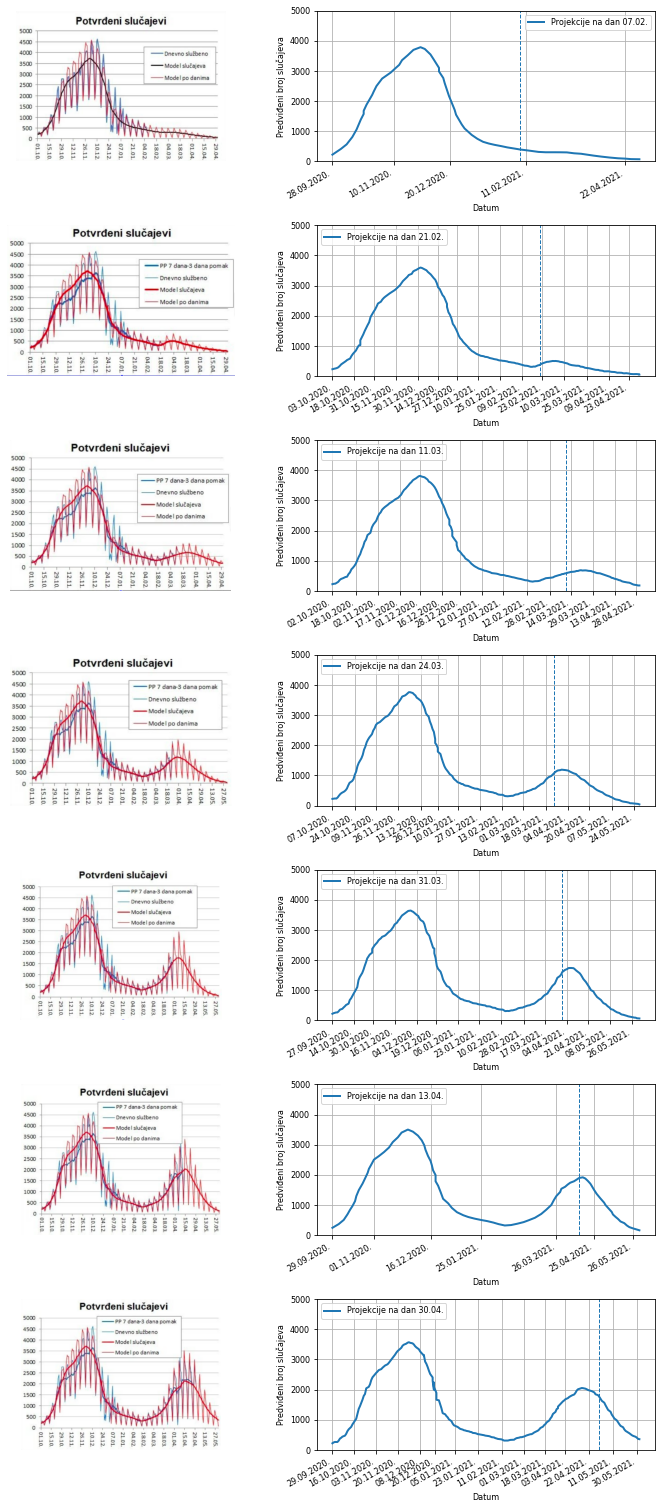

In [25]:
# plot source images and extracted date

font = {'size'  : 8}
matplotlib.rc('font', **font)

pred_colors = {}

pred_data = {}

fig, ax = plt.subplots(len(csv_to_date), 2, figsize=(10, 3 * len(csv_to_date)))

for plot_index, csv_path in enumerate(csvs):
    pred_dates = []
    
    if 'cases' not in str(csv_path):
        continue 
    
    current_img = Image.open(Path('img/{}.png'.format(csv_path.name[:-4])))
    
    ax[plot_index, 0].imshow(current_img)
    ax[plot_index, 0].axis('off')
    
    current_csv = read_csv(csv_path, header=None)
    
    prediction_date = csv_to_date[csv_path.name] 
    
    dates = current_csv[0].to_numpy()
    vals = current_csv[1].to_numpy()
    
    x = [dt.datetime.strptime(d,'%Y/%m/%d').date() for d in dates]

    ax[plot_index, 1].set_xticks(x[::14])
    ax[plot_index, 1].set_xticklabels([d.strftime('%d.%m.%Y.') for d in x[::14]])
    
    
    filtered_dates = []
    filtered_vals = []
    
    for i, (d, v) in enumerate(zip(x, vals)):
        if prediction_date - d < dt.timedelta(days=3):
            filtered_dates.append(d)
            filtered_vals.append(v)
        
    x_num = mdates.date2num(filtered_dates)
    shift = x_num.min()
    x_num -= shift

    n_deg = 6
    
    prediction_fit = np.poly1d(np.polyfit(x_num, filtered_vals, n_deg))
            
    pred_date_num = mdates.date2num(prediction_date)
    
    xx = np.linspace(pred_date_num - shift, x_num.max(), 100)
    dd = mdates.num2date(xx + shift)

    pred_label = 'Projekcije na dan {}'.format(csv_to_date[csv_path.name].strftime('%d.%m.'))
    
    p = ax[plot_index, 1].plot(x, vals, linewidth=2, label=pred_label)
    
    only_future_dates = [d for d in x if prediction_date - d < dt.timedelta(days=1)]
    only_future_vals = [vals[i] for i, d in enumerate(x) if prediction_date - d < dt.timedelta(days=1)]
    
    
    pred_colour = p[-1].get_color()
    
    ax[plot_index, 1].axvline(x=prediction_date, c=p[-1].get_color(), linestyle='--', linewidth=1)

    pred_dates.append(prediction_date)
    pred_colors[prediction_date.strftime('%Y-%m-%d')] = p[-1].get_color()
    
    for t in ax[plot_index, 1].get_xticklabels():
        t.set_rotation(30)
        t.set_ha('right')


    ax[plot_index, 1].set_xlabel('Datum')
    
    ax[plot_index, 1].set_ylim(bottom=0, top=5000)
    ax[plot_index, 1].set_ylabel('Predviđeni broj slučajeva')

    ax[plot_index, 1].grid()
    ax[plot_index, 1].legend()
    
    
# plt.title('Pandemijski realizam: COVID-19 - broj slučajeva - evolucija predikcija Nenada Bakića')
plt.tight_layout()

plt.savefig('img/parsed.png', dpi=200)
plt.show()